In [1]:
%matplotlib notebook
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=16)
import numpy as np
import warnings
import csv
from collections import OrderedDict


from hyperfet.devices import SCMOSFET
from hyperfet.references import si

from functools import reduce
from operator import add
from scipy.optimize import curve_fit
from hyperfet.fitting import show_transistor

# Import simulations from cadence

In [2]:
W=si("2*23nm+10nm")
VDD=.8
prefix='ptm_14nm_lstp_'
ptm=OrderedDict()
for fname in ['idvg','idvd_p45','idvd_p54','idvd_p63','idvd_p72','idvd_p8']:
    with open(prefix+fname+'.csv') as f:
        next(f)
        data=ptm[fname]={}
        data['v'],data['i']=np.hsplit(np.array([[float(x) for x in l.split(',')] for l in f]),2)
        data['i/W']=data['i']/W

# Super rough fit by hand

In [3]:
opts={
    'figsize': (6,7),
    'linidvgpos': [.3,.68,.2,.2],
    'linidvgxticks': [.4,.8],
    'linidvgxlim': [.4,.8],
    'linidvgyticks': [500,1000],
    'linidvdpos': [.62,.25,.25,.3],
    'linidvdxticks': [.4,.8],
    'linidvdyticks': [0,500,1000],
}


<IPython.core.display.Javascript object>


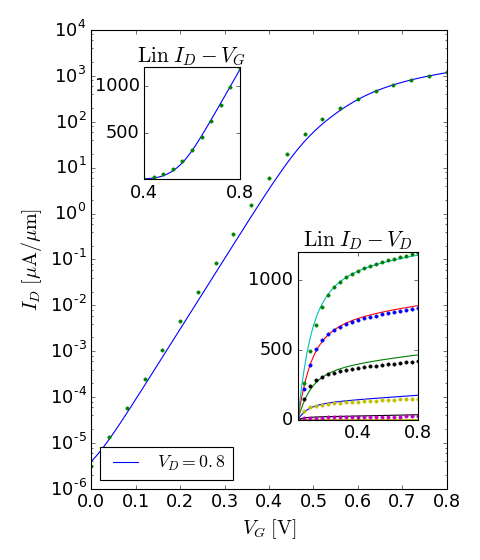

In [5]:
fet_by_hand=None
p0=None
@interact(VT0=FloatSlider(value=.56,min=0,max=1,step=.05,continuous_update=False),
          Cinv_vxo=FloatSlider(value=4700,min=1000,max=5500,step=400,continuous_update=False),
          SS=FloatSlider(value=.065,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=1.5,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.5,min=0,max=4,step=.1,continuous_update=False),
          VDsats=FloatSlider(value=.12,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=.025,min=0,max=.5,step=.1,continuous_update=False),
          log10Gleak=FloatSlider(value=-13,min=-14,max=-5,step=1,continuous_update=False)
         )
def show_HEMT(VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak):
    global fet_by_hand, p0
    fet=SCMOSFET(
        W=W,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    p0=[VT0,Cinv_vxo/1000,SS,alpha,beta,VDsats,delta,log10Gleak]
    show_transistor(fet,VDD,data=ptm,**opts)
    
    fet_by_hand=fet

# Automatic fit refinement

Note that all IDVG currents are in returned as the logarithm, and all IDVD currents are returned as divided by $(100*W)$.  This scaling helps make sure both IDVG and IDVD are reasonably fit.  The Cinv_vxo parameter is scaled down by 1000 in the parameter array to be of the same order as the other parameters

In [6]:
def IVsim(V,*p):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("error")
            VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak=p
            Cinv_vxo*=1000
            fet=SCMOSFET(
                W=W,Cinv_vxo=Cinv_vxo,
                VT0=VT0,alpha=alpha,SS=SS,delta=delta,
                VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
            out=np.array([fet.ID(vd,vg)[0,0]/(100*W) if vd is not None else np.log(fet.ID(VDD,vg)[0,0]) for vd,vg in V])
            return out
    except:
        print(p)


V=list(zip([None]*len(ptm['idvg']['v']),ptm['idvg']['v']))+\
    reduce(add,[list(zip(list(np.ravel(ptm[fname]['v'])),[float(fname.split("_")[1].replace("p","."))]*len(ptm[fname]['v'])))\
            for fname in ptm.keys() if fname.startswith("idvd")])
I=list(np.log(np.ravel(ptm['idvg']['i'])))+\
    reduce(add,[list(np.ravel(ptm[fname]['i'])/(100*W)) for fname in ptm.keys() if fname.startswith("idvd")])
bounds=list(zip(*[(0,1),(3,6),(.06,.1),(0,5),(.5,3),(.05,.5),(0,.1),(-14,-12)]))

pp=curve_fit(IVsim,V,I,p0=p0,bounds=bounds)[0]

0.56649899651 4.82731909909 0.0628444900412 2.90283918549 1.7096458922 0.147342512987 0.0174402541022 -13.818980835


<IPython.core.display.Javascript object>


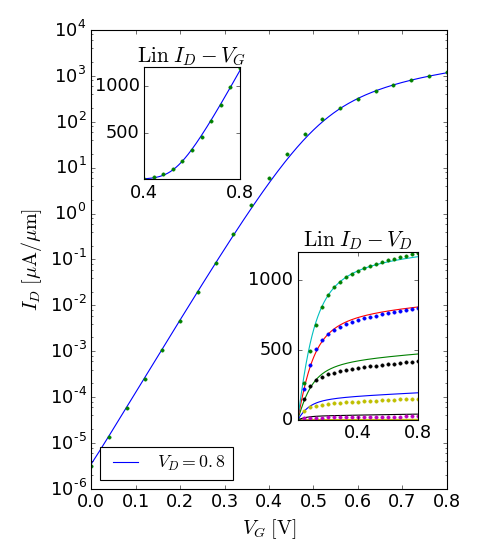

In [7]:
fet_by_fit=None
def show_fitted_HEMT(VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak):
    global fet_by_fit
    print(VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak)
    fet=SCMOSFET(
        W=W,Cinv_vxo=Cinv_vxo*1000,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    show_transistor(fet,VDD,data=ptm,**opts)
    fet_by_fit=fet
show_fitted_HEMT(*pp)

In [7]:
pp

array([  0.566499  ,   4.8273191 ,   0.06284449,   2.90283919,
         1.70964589,   0.14734251,   0.01744025, -13.81898084])